# Model Training

In [1]:
# Import necessary libraries
import sagemaker
from sagemaker import get_execution_role
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Initialize SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Define the S3 bucket and prefix for storing data
bucket = sagemaker_session.default_bucket()  # Default bucket created by SageMaker
prefix = 'emp-bonus-linearlearner'  # Prefix for organizing data in S3

print(f"Using bucket: {bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using bucket: sagemaker-us-east-1-891377300841


In [2]:
# Load the dataset 

df = pd.read_csv(f's3://{bucket}/output/transformed_data.csv')
print(df.head())


    age   salary   bonus  address_length  dept_Finance  dept_HR  dept_IT  \
0  77.0  60000.0  8767.0              18             0        0        0   
1  62.0  50000.0  7553.0              17             0        0        0   
2  61.0  60000.0  6796.0               3             0        1        0   
3  36.0  70000.0  8712.0              17             0        0        0   
4  78.0  60000.0  3340.0              18             0        0        1   

   dept_Marketing  dept_Unknown  age_Young  age_Early Career  age_Mid Career  \
0               1             0          0                 0               0   
1               1             0          0                 0               0   
2               0             0          0                 0               0   
3               0             1          0                 0               1   
4               0             0          0                 0               0   

   age_Senior  age_Experienced  salary_low  salary_medium  sal

In [3]:
# Separate features and target
X = df.drop(columns=['bonus'])  # Drop the target column from the features
y = df['bonus']

# Split the data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 12600 samples
Validation set: 3618 samples
Test set: 1783 samples


In [4]:
# Save the datasets to CSV
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

# Save locally
os.makedirs('data', exist_ok=True)
train_data.to_csv('data/train.csv', index=False, header=False)
val_data.to_csv('data/validation.csv', index=False, header=False)
test_data.to_csv('data/test.csv', index=False)

# Upload to S3
train_path = sagemaker_session.upload_data('data/train.csv', bucket=bucket, key_prefix=f'{prefix}/train')
val_path = sagemaker_session.upload_data('data/validation.csv', bucket=bucket, key_prefix=f'{prefix}/validation')
test_path = sagemaker_session.upload_data('data/test.csv', bucket=bucket, key_prefix=f'{prefix}/test')

print(f"Train data uploaded to: {train_path}")
print(f"Validation data uploaded to: {val_path}")

Train data uploaded to: s3://sagemaker-us-east-1-891377300841/emp-bonus-linearlearner/train/train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-891377300841/emp-bonus-linearlearner/validation/validation.csv


In [5]:
from sagemaker.estimator import Estimator

# Specify the container image for Linear Learner (built-in algorithm)
linear_learner_container = sagemaker.image_uris.retrieve('linear-learner', sagemaker_session.boto_region_name)

# Define the LinearLearner estimator
linear_estimator = Estimator(
    image_uri=linear_learner_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters for Linear Learner
linear_estimator.set_hyperparameters(
    predictor_type='regressor',  # We're solving a regression problem
    mini_batch_size=32,
    epochs=10
)

In [6]:
from sagemaker.inputs import TrainingInput

# Specify the input data channels
train_input = TrainingInput(s3_data=train_path, content_type='text/csv')
val_input = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
linear_estimator.fit({'train': train_input, 'validation': val_input})

INFO:sagemaker:Creating training-job with name: linear-learner-2025-07-27-19-25-24-612


2025-07-27 19:25:26 Starting - Starting the training job...
2025-07-27 19:25:39 Starting - Preparing the instances for training...
2025-07-27 19:26:04 Downloading - Downloading input data...
2025-07-27 19:26:44 Downloading - Downloading the training image......
2025-07-27 19:28:00 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/27/2025 19:28:04 INFO 140170680723264] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 

In [8]:
# Deploy the trained model to an endpoint
predictor = linear_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: linear-learner-2025-07-27-19-33-10-623
INFO:sagemaker:Creating endpoint-config with name linear-learner-2025-07-27-19-33-10-623
INFO:sagemaker:Creating endpoint with name linear-learner-2025-07-27-19-33-10-623


-------!

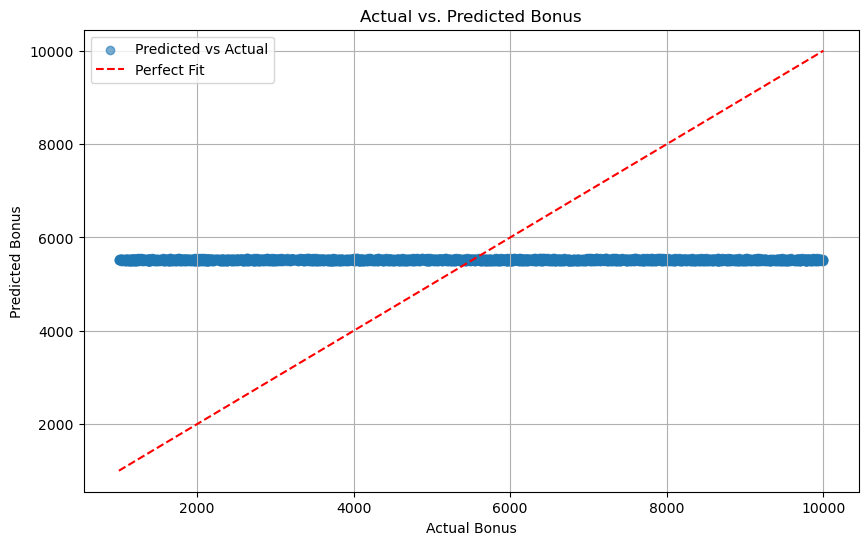

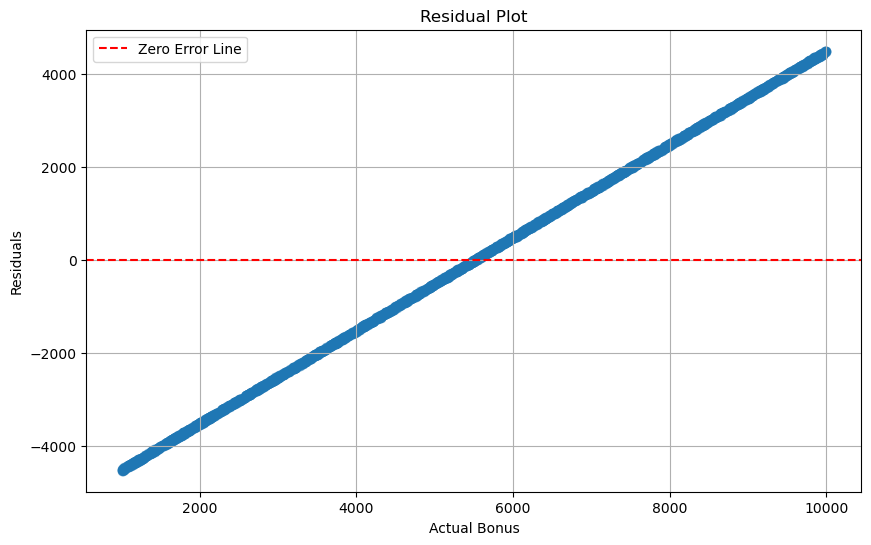

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Prepare payload in CSV format
payload = "\n".join(",".join(map(str, row)) for row in X_val.values)

# Send the payload to the endpoint
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})

# Extract predictions from the response
predicted_bonus = np.array([float(pred['score']) for pred in json.loads(response.decode('utf-8'))['predictions']])

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, predicted_bonus, alpha=0.6, label="Predicted vs Actual")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Bonus")
plt.ylabel("Predicted Bonus")
plt.title("Actual vs. Predicted Bonus")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Residual Plot
residuals = y_val - predicted_bonus
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Actual Bonus")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.show()

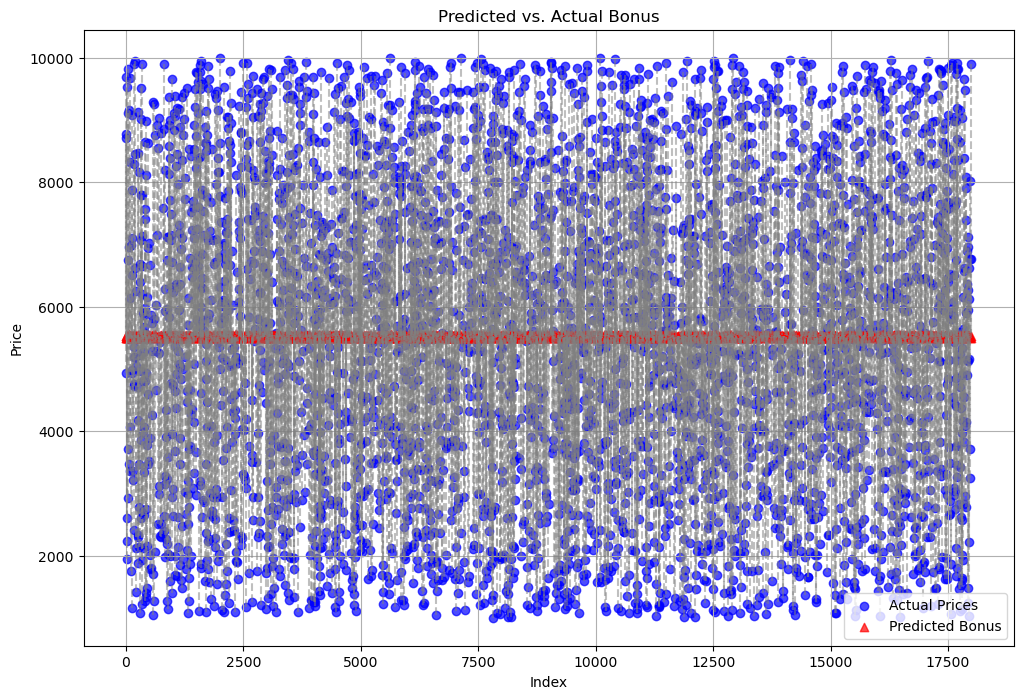

In [12]:
# Visualization: Predicted vs Actual Prices with Distinct Styling
plt.figure(figsize=(12, 8))

# Scatter actual prices
plt.scatter(y_val.index, y_val, color='blue', label='Actual Prices', alpha=0.7, marker='o')

# Scatter predicted prices
plt.scatter(y_val.index, predicted_bonus, color='red', label='Predicted Bonus', alpha=0.7, marker='^')

# Connect actual and predicted prices for each point
for i in range(len(y_val)):
    plt.plot([y_val.index[i], y_val.index[i]], [y_val.iloc[i], predicted_bonus[i]], color='gray', alpha=0.5, linestyle='--')

# Add labels and legend
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Predicted vs. Actual Bonus")
plt.legend()
plt.grid(True)

plt.show()